In [1]:
import tensorflow as tf
import numpy as np
import urllib
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# 옵션
vocab_size = 1000  # 단어사전 크기
embedding_dim = 16 # embedding 차원
max_length = 120   # 문장의 최대길이
trunc_type='post'  # 문장이 최대길이보다 길때 뒤에부분을 자름
padding_type='post'# 문장이 최대길이보다 짧을때 뒤에부분에 0을 채움 
oov_tok = "<OOV>"  # out of vocab
training_size = 20000

In [3]:
# 데이터 가져오기

url = 'https://storage.googleapis.com/download.tensorflow.org/data/sarcasm.json'
urllib.request.urlretrieve(url, 'sarcasm.json')

df = pd.read_json('/content/sarcasm.json')
df.head(5)

,article_link,headline,is_sarcastic
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret 'b...,0
1,https://www.huffingtonpost.com/entry/roseanne-...,the 'roseanne' revival catches up to our thorn...,0
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear son's web series closest ...,1
3,https://politics.theonion.com/boehner-just-wan...,"boehner just wants wife to listen, not come up...",1
4,https://www.huffingtonpost.com/entry/jk-rowlin...,j.k. rowling wishes snape happy birthday in th...,0


In [4]:
# x, y 데이터 분리
headline = df['headline']
labels = df['is_sarcastic']

# train, valid 데이터 분리
train_headline = headline[:training_size]
train_labels = labels[:training_size]

valid_headline = headline[training_size:]
valid_labels = labels[training_size:]

In [5]:
# tokenizer 정의
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=vocab_size,oov_token=oov_tok)

In [6]:
# 학습 문장 토큰화(단어사전 만들기)
tokenizer.fit_on_texts(train_headline)

# 단어사전 확인
print(f"단어수 : {len(tokenizer.word_index)}\n")
for key, value in tokenizer.word_index.items():
    print(f"{key} ==> {value}")

    if value == 15:
        break

단어수 : 25637

<OOV> ==> 1
to ==> 2
of ==> 3
the ==> 4
in ==> 5
for ==> 6
a ==> 7
on ==> 8
and ==> 9
with ==> 10
is ==> 11
new ==> 12
trump ==> 13
man ==> 14
from ==> 15


In [7]:
# 문장을 토큰으로 변경
train_sequences = tokenizer.texts_to_sequences(train_headline)
valid_sequences = tokenizer.texts_to_sequences(valid_headline)

In [8]:
# 문장 길이 맞추기
train_padded = tf.keras.preprocessing.sequence.pad_sequences(train_sequences,truncating=trunc_type,padding=padding_type,maxlen=max_length)
valid_padded = tf.keras.preprocessing.sequence.pad_sequences(valid_sequences,truncating=trunc_type,padding=padding_type,maxlen=max_length)

In [9]:
# ndarray로 만들어주기
train_padded = np.array(train_padded)
valid_padded = np.array(valid_padded)

In [10]:
# 모델링
model = tf.keras.models.Sequential([
                                   tf.keras.layers.Embedding(vocab_size,embedding_dim,input_length=max_length),
                                   tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
                                   tf.keras.layers.Dense(128,activation='relu'),
                                   tf.keras.layers.Dense(32,activation='relu'),
                                   tf.keras.layers.Dense(1,activation='sigmoid')
])

In [11]:
# 최적화 함수, 손실 함수, 평가 지표
optimizer = tf.keras.optimizers.Adam(lr=1e-4)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['acc'])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [12]:
# 체크 포인트 설정
checkpoint_path = 'my_checkpoint.ckpt'
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                save_weights_only=True,
                                                save_best_only=True,
                                                monitor='val_loss',
                                                verbose=1)

In [13]:
# 모델 학습
hist = model.fit(train_padded, train_labels,
                 validation_data = (valid_padded, valid_labels),
                 epochs=30,
                 callbacks=[checkpoint])

Epoch 1/30
625/625 [==============================] - 12s 14ms/step - loss: 0.6269 - acc: 0.6256 - val_loss: 0.4611 - val_acc: 0.7837

Epoch 00001: val_loss improved from inf to 0.46113, saving model to my_checkpoint.ckpt
Epoch 2/30
625/625 [==============================] - 8s 12ms/step - loss: 0.4131 - acc: 0.8096 - val_loss: 0.4136 - val_acc: 0.8125

Epoch 00002: val_loss improved from 0.46113 to 0.41356, saving model to my_checkpoint.ckpt
Epoch 3/30
625/625 [==============================] - 8s 12ms/step - loss: 0.3767 - acc: 0.8313 - val_loss: 0.3925 - val_acc: 0.8222

Epoch 00003: val_loss improved from 0.41356 to 0.39247, saving model to my_checkpoint.ckpt
Epoch 4/30
625/625 [==============================] - 8s 13ms/step - loss: 0.3593 - acc: 0.8362 - val_loss: 0.3894 - val_acc: 0.8195

Epoch 00004: val_loss improved from 0.39247 to 0.38943, saving model to my_checkpoint.ckpt
Epoch 5/30
625/625 [==============================] - 8s 13ms/step - loss: 0.3497 - acc: 0.8422 - val_l

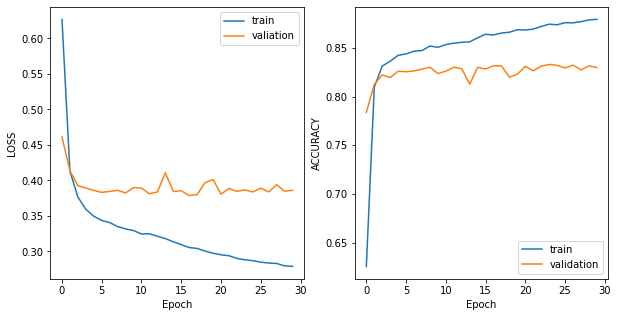

In [14]:
# accuracy, loss 그래프
fig, axes = plt.subplots(1,2, figsize=(10, 5))

## Accuracy
axes[0].plot(hist.history['loss'], label='train')
axes[0].plot(hist.history['val_loss'], label='valiation')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('LOSS')
axes[0].legend()

## Loss
axes[1].plot(hist.history['acc'], label='train')
axes[1].plot(hist.history['val_acc'], label='validation')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('ACCURACY')
axes[1].legend()

plt.show()

In [15]:
# 모델 가중치 적용
model.load_weights(checkpoint_path)

In [17]:
# 모델 저장
model.save('sarcasm.h5')